In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time

import torch
import pickle
import qgrid

import matplotlib.pyplot as plt
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

from scipy.io import wavfile
import scipy.fftpack as fftpack

In [2]:
data = pd.read_csv('../data/data.csv', index_col=0)

In [21]:
data.to_csv('../data/data.csv')

## Parameters

In [4]:
normalize = False 
sample_rate = 44100
frame_sizes = [1024, 2048, 4096]
frame_rate = 100
hop_size = sample_rate/frame_rate
window = [np.hamming(frame_size) for frame_size in frame_sizes]
num_fft_bins = [frame_size >> 1 for frame_size in frame_sizes]

bin_frequencies = []
for i in range(len(frame_sizes)):
    bin_frequencies.append(np.fft.fftfreq(frame_sizes[i], 1. / sample_rate)[:num_fft_bins[i]])

## Functions

In [5]:
# Functions 

def signal_frame(signal, index, frame_size, hop_size, origin=0):
    
    frame_size = int(frame_size)
    num_samples = len(signal)
    ref_sample = int(index * hop_size)
    start = ref_sample - frame_size // 2 - int(origin)
    stop = start + frame_size

    if (stop < 0) or (start > num_samples):
        # window falls completely outside the actual signal, return just zeros
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        return frame
    elif (start < 0) and (stop > num_samples):
        # window surrounds the actual signal, position signal accordingly
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:num_samples - start] = signal
        return frame
    elif start < 0:
        # window crosses left edge of actual signal, pad zeros from left
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:] = signal[:stop, ]
        return frame
    elif stop > num_samples:
        # window crosses right edge of actual signal, pad zeros from right
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[:num_samples - start] = signal[start:, ]
        return frame
    # normal read operation
    return signal[start:stop, ]

def hz2mel(f):
    return 1127.01048 * np.log(np.asarray(f) / 700. + 1.)

def mel2hz(m):
    return 700. * (np.exp(np.asarray(m) / 1127.01048) - 1.)

def mel_frequencies(num_bands, fmin, fmax):
    return mel2hz(np.linspace(hz2mel(fmin), hz2mel(fmax), num_bands))

def frequencies2bins(frequencies, bin_frequencies):
    indices = bin_frequencies.searchsorted(frequencies)
    left = bin_frequencies[indices - 1]
    right = bin_frequencies[indices]
    indices -= frequencies - left < right - frequencies
    return indices

def bins2filterbank(bins, num_fft_bins):
    filterbank = []
    index = 0
    for index in range(len(bins)-2):
        start, center, end = bins[index: index + 3]
        filt = np.zeros(num_fft_bins)
        # rising edge (without the center)
        filt[start:center] = np.linspace(0, 1, center - start, endpoint=False)
        # falling edge (including the center, but without the last bin)
        filt[center:end] = np.linspace(1, 0, end - center, endpoint=False)
        filterbank.append(filt)
    return filterbank

def create_filterbank(bin_frequencies, num_fft_bins, num_bands = 20, fmin = 20., fmax = 17000.):
    frequencies = mel_frequencies(num_bands + 2, fmin, fmax)
    bins = frequencies2bins(frequencies, bin_frequencies)
    filterbank = bins2filterbank(bins, num_fft_bins)
    return np.asarray(filterbank)

def quantize_events(events, fps, length):
    events = np.array(events, dtype=np.float)
    
    events = events[:np.searchsorted(events, float(length - 0.5) / fps)]

    quantized = torch.zeros(length, dtype=torch.long)

    events *= fps
    
    # indices to be set in the quantized array
    idx = np.unique(np.round(events).astype(np.int))
    quantized[idx] = 1

    return quantized

def half_wave_rectifier(arr):
    return (np.abs(arr) + arr) / 2.0

filterbank = []
for i in range(len(frame_sizes)):
    filterbank.append(np.array(create_filterbank(bin_frequencies[i], num_fft_bins[i]), dtype='float32'))

In [6]:
def get_audio(file, normalize=False):
    _, signal = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    if normalize:
        signal = signal / np.max(np.abs(signal))
    return signal

def get_sample_rate(file, normalize=False):
    sr, _ = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    return sr

def play_audio(file, normalize=False):
    sr, signal = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    
    if normalize:
        signal = signal / np.max(np.abs(signal))    
        
    return ipd.Audio(signal, rate=sr)

def get_input(file):
    return pickle.load(open('../data/inputs/'+ file + '.npy', 'rb'))

def get_annotations(file):
    return np.loadtxt('../data/annotations/' + file + '.beats', ndmin=2)[:, 0]

def get_predictions(file):
    return np.loadtxt('../data/predictions/' + file + '.beats')

def play_annotations(file, normalize=True):
    sr, signal = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    
    if normalize:
        signal = signal / np.max(np.abs(signal))
        
    metronome = clicks(get_annotations(file), sr=sr, length=len(signal))

    signal = signal + metronome
        
    signal = signal / np.max(np.abs(signal))
        
    return ipd.Audio(signal, rate=sr)

def play_predictions(file, normalize=True):
    sr, signal = wavfile.read('../data/audio/' + file + '.wav', mmap=False)
    
    if normalize:
        signal = signal / np.max(np.abs(signal))
        
    metronome = clicks(get_predictions(file), sr=sr, length=len(signal))

    signal = signal + metronome
        
    signal = signal / np.max(np.abs(signal))
        
    return ipd.Audio(signal, rate=sr)

## Process files

In [9]:
files = data['file'][data['data_set'] == 2]

start = time.time()
for i, file in enumerate(files):
    
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    
    # Load audio
    signal = get_audio(file)
    annotations = get_annotations(file)
    
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    
    feature = []
    
    for j, frame_size in enumerate(frame_sizes): 
    
        frames = []    

        # Slice audio into frames
        for index in range(num_frames):
            frames.append(signal_frame(signal, index, frame_size, hop_size))

        # Compute FFT    
        fft = np.empty((num_frames, num_fft_bins[j]), np.complex64)

        for f, frame in enumerate(frames):
            fft_signal = np.multiply(frame, window[j])
            fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins[j]]

        abs_fft = np.square(np.abs(fft))

        filt_spec = np.log(np.dot(abs_fft, filterbank[j].T) + 1.0)
        
        shift_length = np.int(frame_size/100.)
        
        median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
                  [:-shift,:] for shift in range(1, shift_length+1)]
        median = np.insert(median, 0, filt_spec, axis=0)
        median = np.median(median, axis=0)
        
        diff_spec = half_wave_rectifier(filt_spec - median)
        diff_spec[:shift_length,:] = 0
        
        if normalize:
            filt_spec = filt_spec - np.min(filt_spec)
            filt_spec = filt_spec / np.max(filt_spec)
            diff_spec = diff_spec - np.min(diff_spec)
            diff_spec = diff_spec / np.max(diff_spec)
               
        feature.append(torch.tensor(filt_spec, dtype=torch.float32)) 
        feature.append(torch.tensor(diff_spec, dtype=torch.float32)) 
      
    feature_vec = torch.cat(feature, 1)
    pickle.dump(feature_vec, open('../data/inputs/' + '/' +
                                  file + '.npy', 'wb'), protocol=2)
    
    labels = quantize_events(annotations, fps=frame_rate, length=num_frames)
    pickle.dump(labels, open('../data/labels/' +  '/' +
                                  file + '.npy', 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 217 of 217
Elapsed time: 4 min and 4 s


## Example 

Text(0.5,0,'Time [s]')

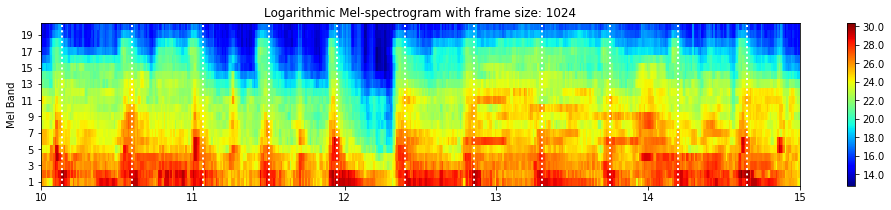

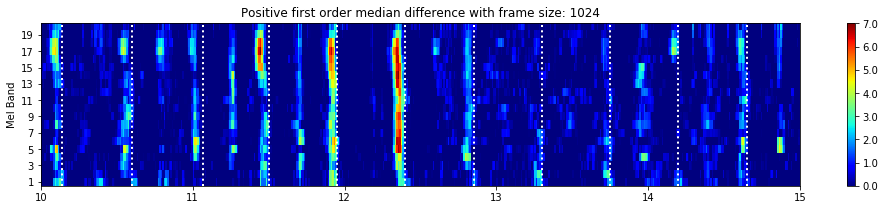

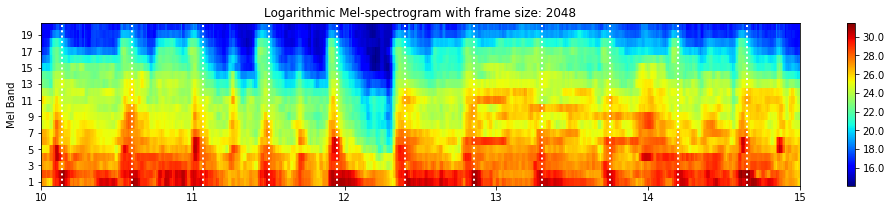

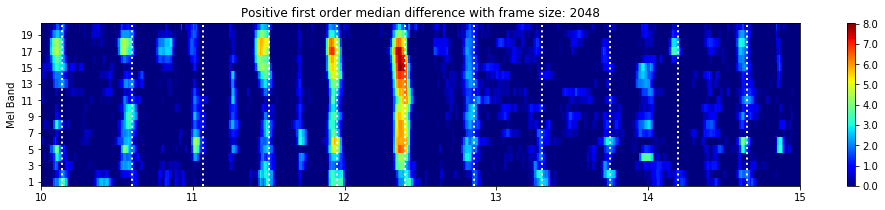

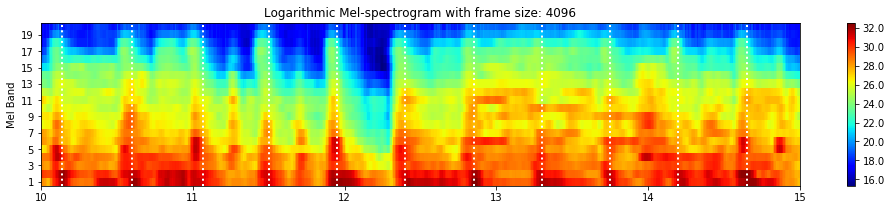

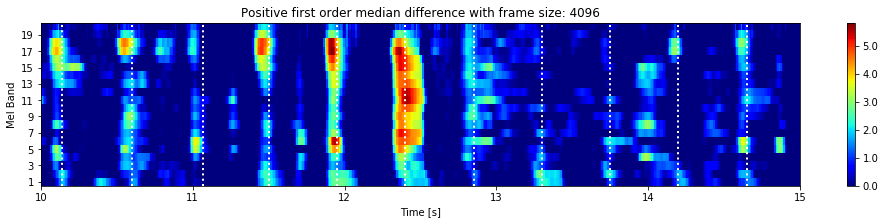

In [30]:
index = 260

input = get_input(data.at[index,'file'])
annotations = get_annotations(data.at[index,'file'])
predictions = get_predictions(data.at[index,'file'])

start = 10
end = 15
num_bands = 20
frame_rate = 100

title = ['Logarithmic Mel-spectrogram with frame size: 1024', 
         'Positive first order median difference with frame size: 1024',
         'Logarithmic Mel-spectrogram with frame size: 2048', 
         'Positive first order median difference with frame size: 2048',
         'Logarithmic Mel-spectrogram with frame size: 4096', 
         'Positive first order median difference with frame size: 4096']

for i in range(6):
    plt.figure(figsize=(17,3))
    plt.title(title[i])

    plt.imshow(np.array(input).T[i*20:(i+1)*20,start*frame_rate:end*frame_rate], 
               extent=(start,end, 0.5, num_bands+0.5),
               origin='lower', aspect='auto',cmap='jet');
    plt.yticks(np.arange(1,20,2));
    plt.ylim(0.5,num_bands+0.5)

    plt.colorbar(format='%.1f');
    
    plt.ylabel('Mel Band');

    for ann in predictions:
        plt.axvline(x=ann, color='w', linestyle=':', linewidth=2)
    plt.xlim(start, end)

plt.xlabel('Time [s]')


Wie sollen die Features normalisiert werden? <br>
Mit Hinblick auf die Eingangsdaten?

## Appendix

In [14]:
# Median Bildung
a = np.random.randn(5,3)
# print('a:\n', a, '\n')

shift_length = 5

median = [np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-shift,:] for shift in range(1, shift_length+1)]
median = np.insert(median, 0, a, axis=0)

# print('median:\n', median)

median = np.median(median, axis=0)

# shift = 1
# np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-1,:]



## Create splits for cross validation

In [5]:
len_dataset = len(files)
nr_folds = 8 

len_test = int((1 / nr_folds) * len_dataset)

# Random split
np.random.seed(0)
perm = np.random.permutation(len_dataset)

In [10]:
for fold in range(nr_folds):
    indices_test = np.sort(perm[len_test*fold:len_test*(fold+1)])
    subfiles = [files[i] for i in indices_test]
    np.savetxt('../data/splits/Ballroom/indices_'+str(fold)+'.fold', indices_test, delimiter=',',fmt='%.i',)
    np.savetxt('../data/splits/Ballroom/files_'+str(fold)+'.fold', subfiles, delimiter=',',fmt='%s',)